In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_samples, silhouette_score
import scipy.cluster.hierarchy as shc
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

# Data loading and cleansing

In [5]:
data=pd.read_csv("form_questions.csv")

In [6]:
#to clean up the data
lemmatizer = WordNetLemmatizer()
strip_special_chars = re.compile("[^A-Za-z0-9 ]+")
stop_words = set(stopwords.words("english"))

def cleanUpSentence(r, stop_words = None):
    r = r.lower().replace("<br />", " ")
    r = re.sub(strip_special_chars, "", r.lower())
    if stop_words is not None:
        words = word_tokenize(r)
        filtered_sentence = []
        for w in words:
            w = lemmatizer.lemmatize(w)
            if w not in stop_words:
                filtered_sentence.append(w)
        return " ".join(filtered_sentence)
    else:
        return r

In [7]:
data.head()

,question
0,Are you there?
1,Firstname:
2,I get irritated easily.
3,Comments
4,Let's do a survey about exercising?


In [8]:
data.shape

(4307, 1)

In [9]:
totalX = []
for i, row in data.iterrows():
    question= row['question']
    totalX.append(cleanUpSentence(str(question), stop_words))

In [10]:
len(totalX)

4307

# Using tf-idf vectorising technique to get vectors for documents

In [139]:
max_features=2000
# Keep only 10000 top words in the vocabulary
vectorizer = TfidfVectorizer(max_features=max_features,use_idf=True)
#for training data of christian data
tfidf_score = vectorizer.fit_transform(totalX)
tfidf_score = tfidf_score.toarray() # Switch from sparse matrix to full matrix
feature_names =vectorizer.get_feature_names()

In [140]:
tfidf_score.shape

(4307, 2000)

# Lets perform clustering on top of tf-idf vectors

# Hirerachical Clustering - to get an idea about clusters

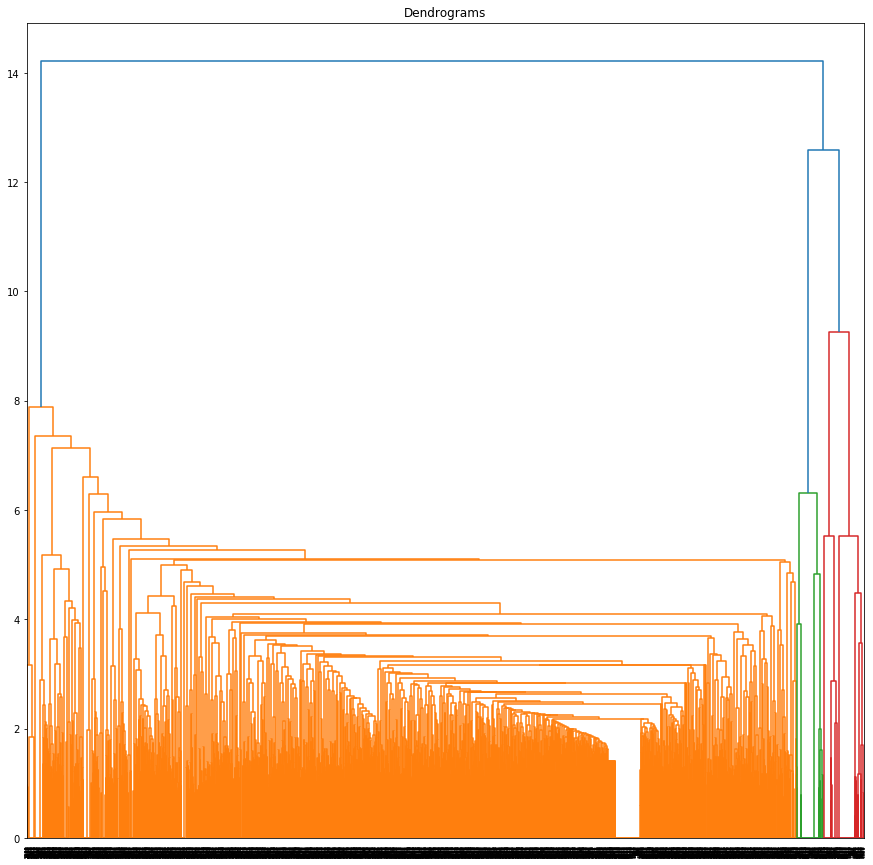

In [141]:
plt.figure(figsize=(15, 15))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(tfidf_score, method='ward'))
#from below graph we can detect three clusters

# Elbow Analysis to find K, the number of clusters for k-means

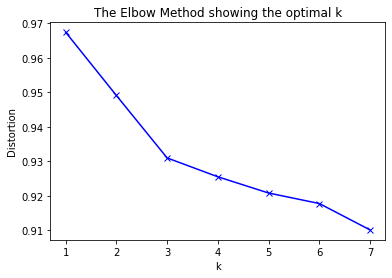

In [57]:
# k means determine k
distortions = []
K = range(1,8)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(tfidf_score)
    distortions.append(sum(np.min(cdist(tfidf_score, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / tfidf_score.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

# Silhouette analysis - evaluation method for clustering 

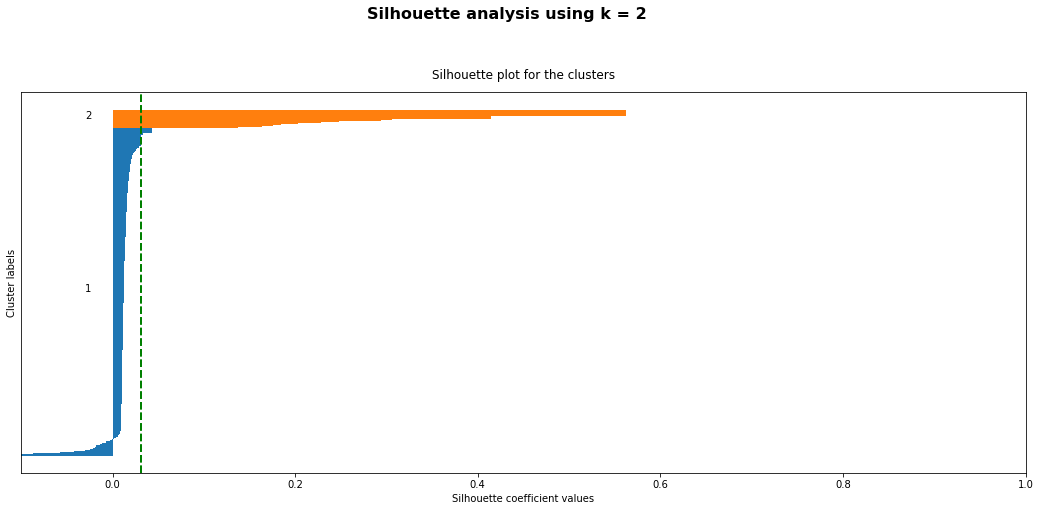

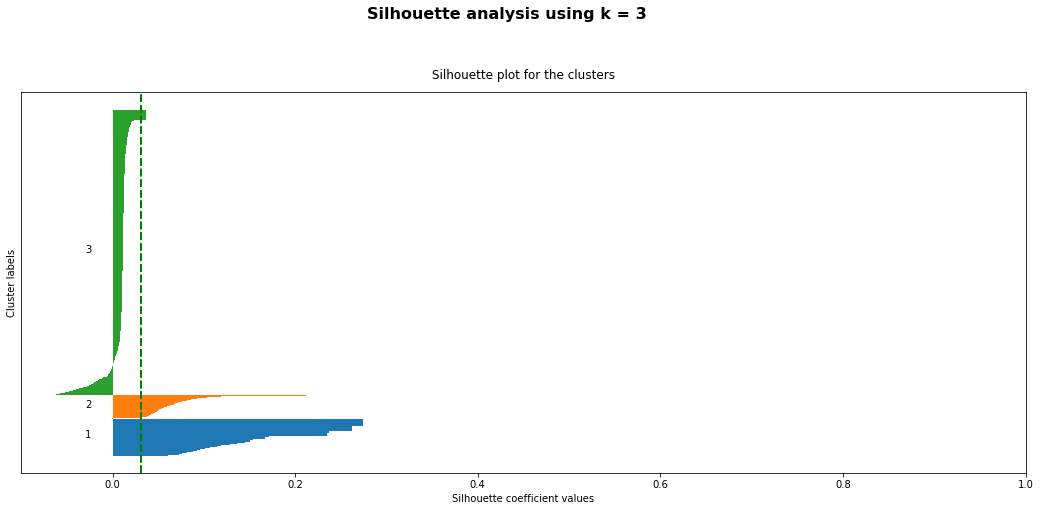

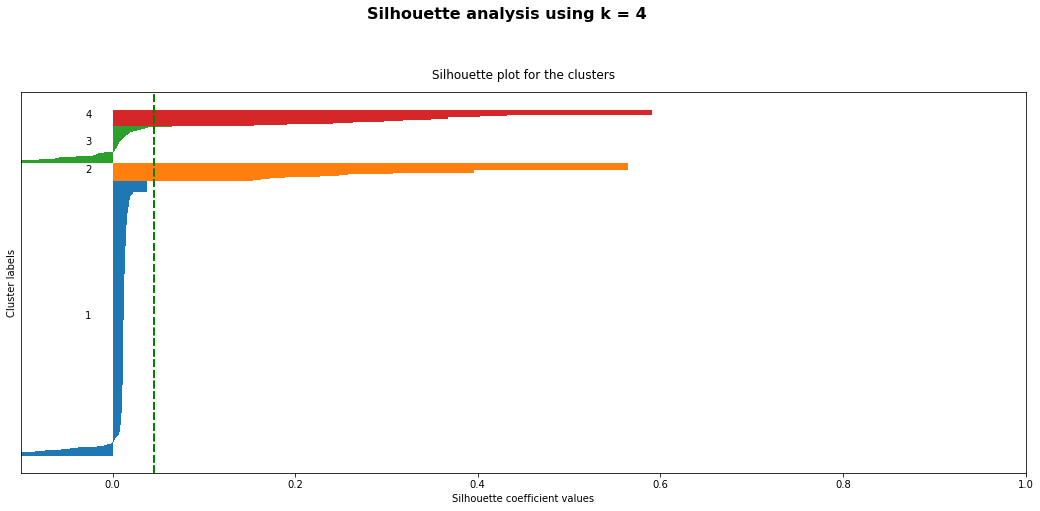

In [65]:
for i, k in enumerate([2, 3, 4]):
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(tfidf_score)
    centroids = km.cluster_centers_
    # Get silhouette samples
    silhouette_vals = silhouette_samples(tfidf_score, labels)
    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)
        # Get the average silhouette score and plot it
        avg_score = np.mean(silhouette_vals)
        ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
        ax1.set_yticks([])
        ax1.set_xlim([-0.1, 1])
        ax1.set_xlabel('Silhouette coefficient values')
        ax1.set_ylabel('Cluster labels')
        ax1.set_title('Silhouette plot for the clusters', y=1.02);
        plt.suptitle(f'Silhouette analysis using k = {k}',
                 fontsize=16, fontweight='semibold', y=1.05);

# Spectral clutering

In [121]:
for i, k in enumerate([2, 3, 4]):
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)
    # Run the Kmeans algorithm
    clustering = SpectralClustering(n_clusters=k, assign_labels="discretize", random_state=0).fit(tfidf_score)
    labels = clustering.fit_predict(tfidf_score)    
    # Get silhouette samples
    silhouette_vals = silhouette_samples(tfidf_score, labels)
    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)
        # Get the average silhouette score and plot it
        avg_score = np.mean(silhouette_vals)
        ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
        ax1.set_yticks([])
        ax1.set_xlim([-0.1, 1])
        ax1.set_xlabel('Silhouette coefficient values')
        ax1.set_ylabel('Cluster labels')
        ax1.set_title('Silhouette plot for the clusters', y=1.02);
        plt.suptitle(f'Silhouette analysis using k = {k}',
                 fontsize=16, fontweight='semibold', y=1.05);

# Lets try with deep learning model --- doc2vec model

In [97]:
#Import all the dependencies
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

In [106]:
tagged_data = [TaggedDocument(words=word_tokenize(doc), tags=[str(i)]) for i, doc in enumerate(totalX)]
#tagged_data

# Training data model

In [107]:
max_epochs = 100
vec_size = 100
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
#     print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


# getting embeddings from the trained model

In [116]:
#lets find embeddings for our dataset (question bank)
embeddings=[]
for doc in totalX:
    embeddings=np.append(embeddings,model.infer_vector(test_data),axis=0)

embeddings=embeddings.reshape(len(totalX),vec_size)   
embeddings.shape

(4307, 100)

# HC clustering using embeddings

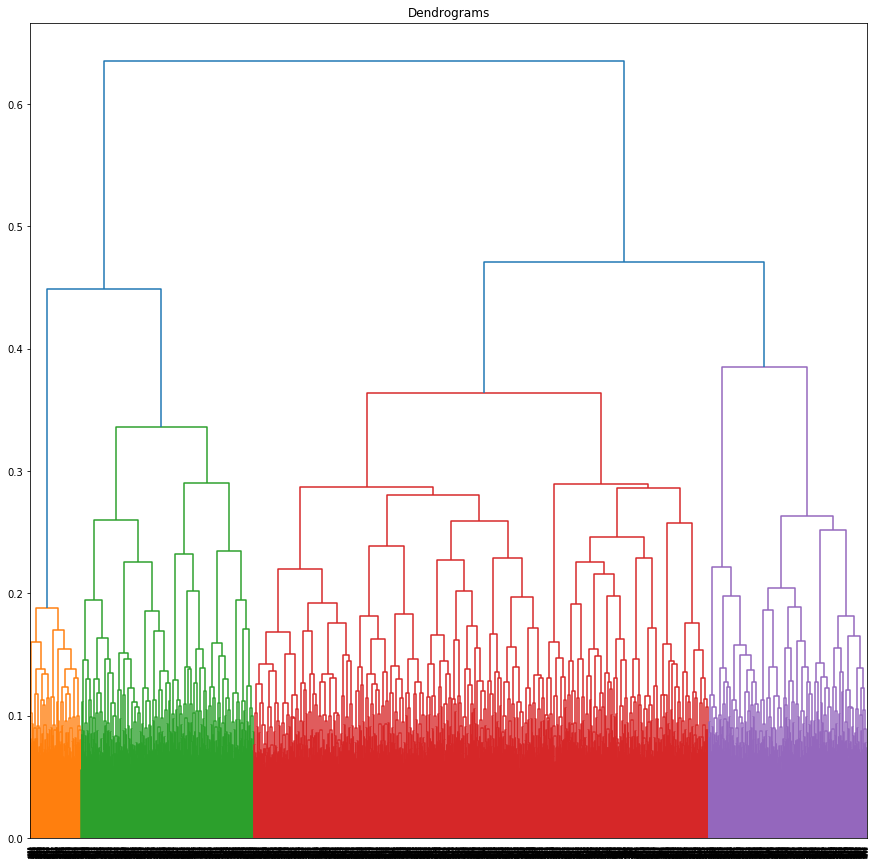

In [117]:
plt.figure(figsize=(15, 15))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(embeddings, method='ward'))
#4 clusters with much more clearity ---- quaility of the embeddings is much better

# K-Means clustering, elbow analysis to find K using embeddings data

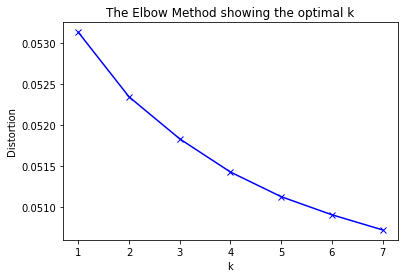

In [119]:
# k means determine k
distortions = []
K = range(1,8)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(embeddings)
    distortions.append(sum(np.min(cdist(embeddings, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / embeddings.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()
#k=4 is valid, obvious from elbow of the curve

# silhouittee analysis with k-means

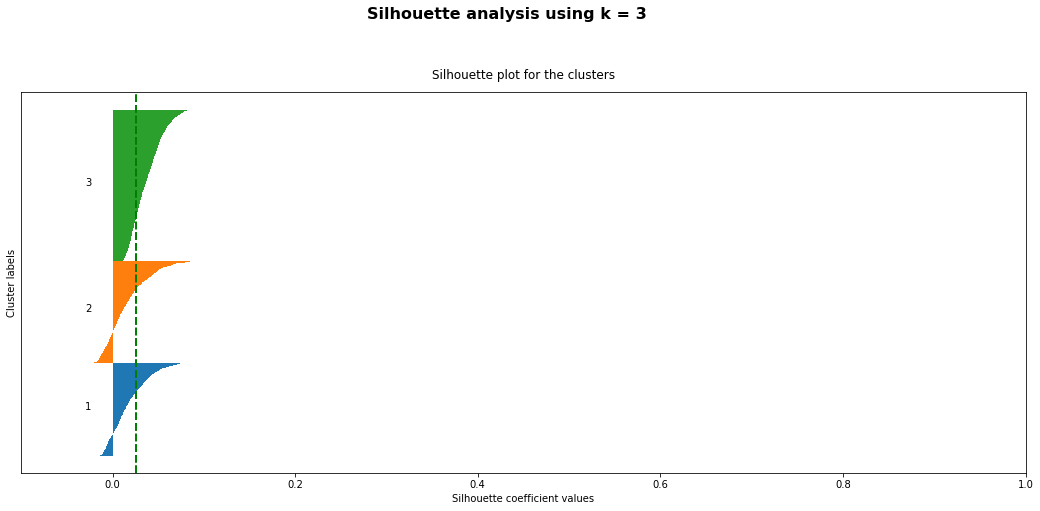

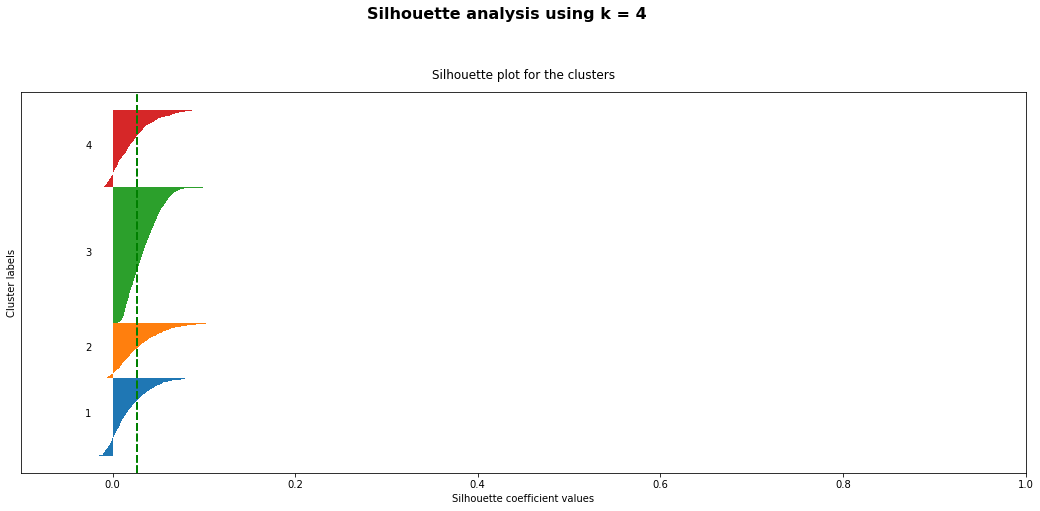

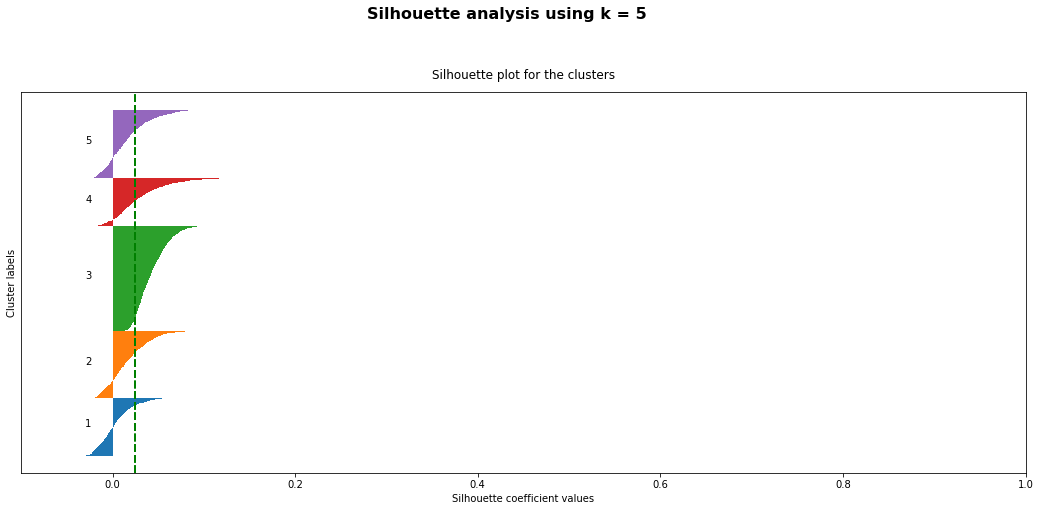

In [124]:
for i, k in enumerate([3, 4, 5]):
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(embeddings)
    centroids = km.cluster_centers_
    # Get silhouette samples
    silhouette_vals = silhouette_samples(embeddings, labels)
    #print(silhouette_vals)
    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)
        # Get the average silhouette score and plot it
        avg_score = np.mean(silhouette_vals)
        ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
        ax1.set_yticks([])
        ax1.set_xlim([-0.1, 1])
        ax1.set_xlabel('Silhouette coefficient values')
        ax1.set_ylabel('Cluster labels')
        ax1.set_title('Silhouette plot for the clusters', y=1.02);
        plt.suptitle(f'Silhouette analysis using k = {k}',
                 fontsize=16, fontweight='semibold', y=1.05);

# Spectral clustering using embeddings data

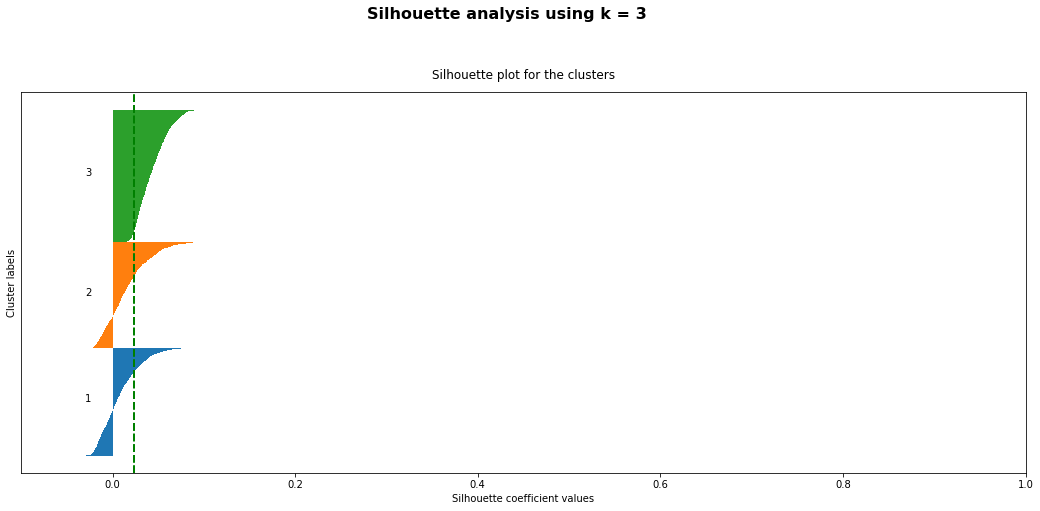

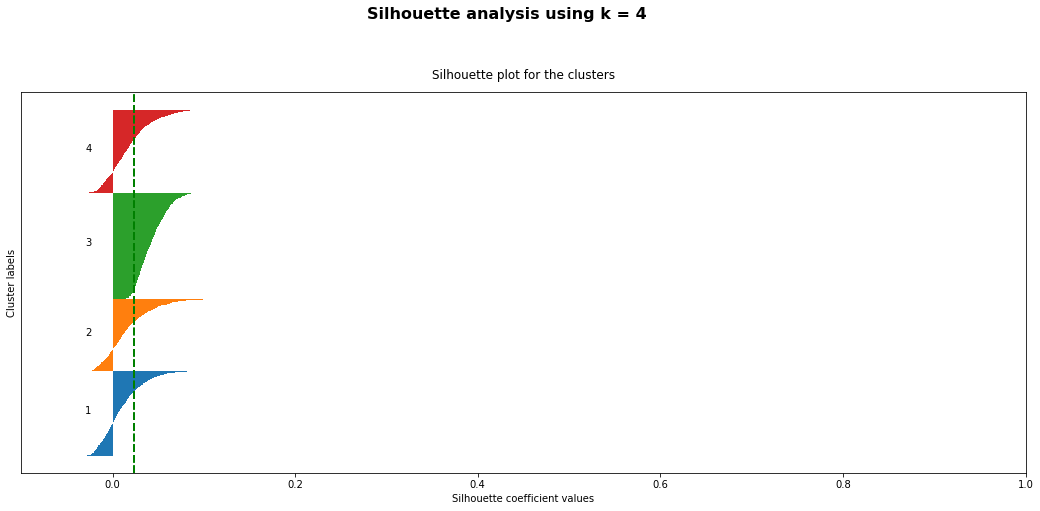

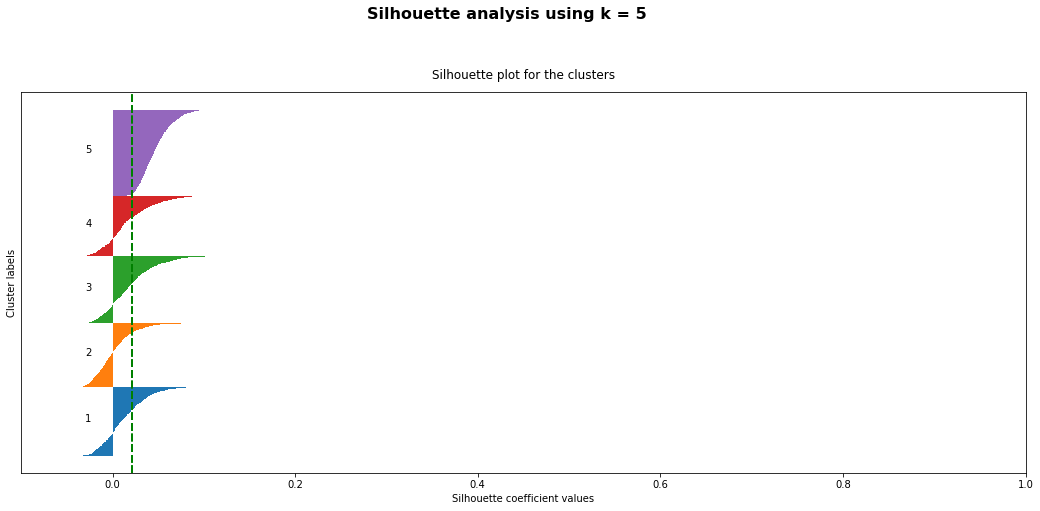

In [122]:
for i, k in enumerate([3, 4, 5]):
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)
    # Run the Kmeans algorithm
    clustering = SpectralClustering(n_clusters=k, assign_labels="discretize", random_state=0).fit(embeddings)
    labels = clustering.fit_predict(embeddings)    
    # Get silhouette samples
    silhouette_vals = silhouette_samples(embeddings, labels)
    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)
        # Get the average silhouette score and plot it
        avg_score = np.mean(silhouette_vals)
        ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
        ax1.set_yticks([])
        ax1.set_xlim([-0.1, 1])
        ax1.set_xlabel('Silhouette coefficient values')
        ax1.set_ylabel('Cluster labels')
        ax1.set_title('Silhouette plot for the clusters', y=1.02);
        plt.suptitle(f'Silhouette analysis using k = {k}',
                 fontsize=16, fontweight='semibold', y=1.05);

# Get doc Embeddings using pre-trained BERT

In [11]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

In [12]:
# tokenized_texts=[word_tokenize(doc) for i, doc in enumerate(totalX)]

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenized_texts=[]
for x in totalX:
    if x == "":
        print(x)
    else:    
        tokenized_text = tokenizer.tokenize(x)
        tokenized_texts.append(tokenized_text)

#print(tokenized_texts)   

tokenized_indexed_texts=[]
for x in tokenized_texts:
    indexed_tokens = tokenizer.convert_tokens_to_ids(x)
    tokenized_indexed_texts.append(indexed_tokens)
#print(tokenized_indexed_texts)

In [13]:
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased')
# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): BertLayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): BertIntermediate(
          (dense): Lin

# Document Embedding using average of the second last Layer

In [14]:
doc_embeddings=[]
ctr=0
for t in np.array(tokenized_indexed_texts):
    ctr+=1
    # Convert inputs to PyTorch tensors
    tokens_tensor = torch.tensor([t])
    segments_tensors = torch.tensor([[1]*len(t)])
         
    # Predict hidden states features for each layer
    with torch.no_grad():
        encoded_layers, _ = model(tokens_tensor, segments_tensors)
    sentence_embedding = torch.mean(encoded_layers[11], 1)
    doc_embeddings.append(np.array(sentence_embedding.tolist()))
    #print(len(doc_embeddings[0][0]))
#     if ctr%30==0:
#         print(ctr)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
#convert list of array to array
doc_embeddings= np.vstack(doc_embeddings)
print(doc_embeddings.shape)

(4213, 768)


# Apply HC clustering BERT embeddings

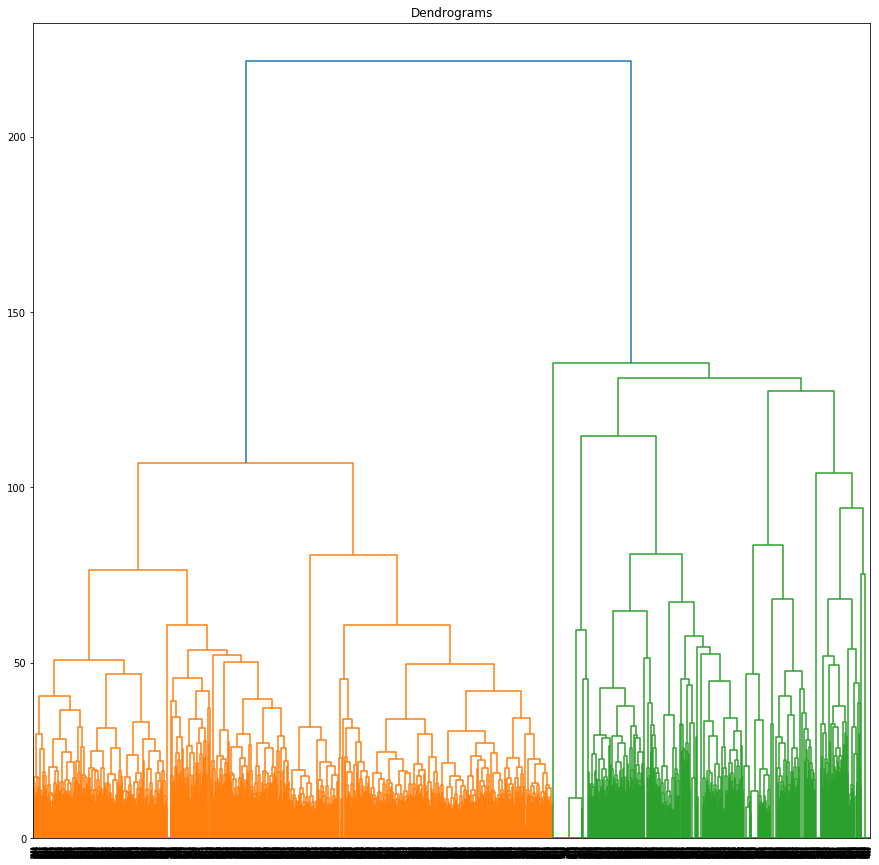

In [15]:
plt.figure(figsize=(15, 15))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(doc_embeddings, method='ward'))
#2 clusters with much more clearity ---- quaility of the embeddings is much much better

# Apply  K-Means clustering using BERT embeddings

In [18]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

#spark context initialization
import findspark
findspark.init()
import pyspark

#get spark context
sc=pyspark.SparkContext(appName="QuestionClustering")


In [17]:
#sc.stop()

In [19]:
#import org.apache.spark.sql.{Row, SparkSession}
from pyspark.sql import  SparkSession 
spark= SparkSession.builder.getOrCreate()

In [25]:
from pyspark.sql.types import FloatType
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

rdd1 = sc.parallelize(doc_embeddings)
rdd2 = rdd1.map(lambda x: [int(i) for i in x])
df=rdd2.toDF()
#df.show(2)

vecAssembler = VectorAssembler(inputCols=df.columns,outputCol="features")
new_df = vecAssembler.transform(df)
#new_df.show()

+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---

In [33]:
# Trains a k-means model.
kmeans = KMeans().setK(2).setSeed(1)
model = kmeans.fit(new_df.select('features'))

# Steps to build intent classification model to tag form questions

In [ ]:
# 1) Define the problem statement --- which is in our case classify the intent of the question
# 2) Analyse it is classification / regression / clustering problem?
# 3) In our case it is supervised classification multi-class classification problem (list of possible intents)?
# 4) Check it is mono labled / multi labled problem? depneds on we have fix list of categories and wheather a question 
#    can belong to multiple tags or not (Business users will help us) 
# 5) Identify data sources from where we can get relevant labeled data set?
# 6) Gather / Collect data from all the identified data sources (SPARK/NoSql/RDBMS/Files/Web/APi's). 
# 7) Preprocess textual data such as ... removing special characters, lowering cases, sentense, word tokenization etc..
# 8) Clean the textual data such as ... remove stop words, perform stemming/lemmatization
# 9) Preparing text to convert into numerical forms for analysis
#    Get embeddings of the questions/documents using Bag of Words (BOW) / tf-idf / word2vec / doc2vec / Deep neural network (LSTM/CNN/BERT)
# 10) Encode classes/target variable using one hot encoding
# 11) Split data into training and test documents
# 12) Apply supervised classification such as SVM/KNN and report performance results for both train and test data
# 13) Hyper parameter tuning can be performed using Gridsearch / cross valisdation for model selection
# 14) Train the model on full data and build pipeline for future predictions and finally deploy in production using flask/Django
#     API and finally docorize/containrize the app to host in cloud environment for serving --- connect with data lakes
# 15) Constanttly monitor the performance of the model